In [1]:
import numpy as np
import coupledIIR as cf
from math import pi
from scipy import signal
from matplotlib import pyplot as plt

# References:
# [1] P.P. Vaidyanathan, ROBUST DIGITAL FILTER STRUCTURES, in HANDBOOK FOR DIGITAL SIGNAL PROCESSING. S.K. Mitra and J.F. Kaiser Eds. Wiley-Interscience, N.Y., 1993, Chapter 7.
# [2] P.P. Vaidyanathan, MULTIRATE SYSTEMS AND FILTER BANKS, Prentice Hall, N.Y., Englewood Cliffs, NJ, 1993, Chapter 3.

In [2]:
def numrecursion(r, N, c):
    q = np.zeros(N + 1, dtype=complex)

    # Initialize recursion
    q[0] = np.sqrt(-r[0] / c, dtype=complex)
    q[N] = np.conj(c * q[0], dtype=complex)
    q[1] = -r[1] / (2 * c * q[0])
    q[N - 1] = np.conj(c * q[1], dtype=complex)

    # The limit of the for loop depends on the order being odd or even
    for n in range(2, int(np.ceil(N / 2))):
        q[n] = (-r[n] / c - np.sum(q[1:n] * q[n-1:0:-1])) / (2 * q[0])
        q[N-n] = np.conj(c * q[n])

    # Compute middle coefficient separately when order is even
    if N % 2 == 0:
        q[int((N+2) / 2) - 1] = (-r[int((N+2) / 2) - 1] / c - np.sum(q[1:int((N+2) / 2) - 1] * q[int((N+2) / 2) - 2::-1])) / (2 * q[0])

    return q

def powercompnum(b, r, N, c=1):
    """
    Compute numerator of power complementary filter.
    """
    # Check if b is real and c has default value
    if np.isreal(b).all() and c == 1:
        # Try to get a real q with c = 1 and c = -1
        q = numrecursion(r, N, 1)

        if not np.isreal(q).all():
            q = numrecursion(r, N, -1)

        if not np.isreal(q).all():
            print('A real power complementary filter could not be found')
            return q
    else:
        if np.size(c) > 1:
            print('C must be a complex scalar.')
            return None
        if abs(c) - 1 > np.power(np.finfo(float).eps, 2/3):
            print('C must be of magnitude one.')
            return None

        q = numrecursion(r, N, c)

    return q

def auxpoly(b, a):
    revb = np.conj(b[::-1])
    reva = np.conj(a[::-1])

    r = np.subtract(np.convolve(revb, b), np.convolve(a, reva))

    return r

def iirpowcomp(b, a):
    # Find the auxiliary polynomial R(z)
    r = auxpoly(b, a)

    # Compute the numerator of the power complementary transfer function
    q = powercompnum(b, r, len(b) - 1)
    return q, a

def sortnums(b, bp):
    # Sort numerators prior to calling ALLPASSDECOMPOSITION.
    # ALLPASSDECOMPOSITION always requires the first argument to
    # be symmetric. The second argument can be symmetric or antisymmetric.

    # If b is real and antisymmetric, make it the second argument
    if np.max(np.abs(np.add(b, b[::-1]))) < np.finfo(float).eps ** (2 / 3):
        p = bp
        q = b
    else:
        p = b
        q = bp

    return p, q

def allpassdecomposition(p, q, a):
    # If q is real and antisymmetric, make it imaginary
    if np.all(np.isreal(q)):
        if np.max(np.abs(np.add(q, q[::-1]))) < np.finfo(float).eps ** (2 / 3):
            q = q * 1j

    z = np.roots(p - 1j * q)

    # Initialize the allpass functions
    d1 = np.array([1.0])
    d2 = np.array([1.0])

    # Separate the zeros inside the unit circle and the ones outside to form the allpass functions
    for n in range(len(z)):
        if np.abs(z[n]) < 1:
            d2 = np.convolve(d2, [1, -z[n]])
        else:
            d1 = np.convolve(d1, [1, -1 / np.conj(z[n])])

    # Remove roundoff imaginary parts
    d1 = imagprune(d1)
    d2 = imagprune(d2)

    beta = np.sum(d2) * (np.sum(p) + 1j * np.sum(q)) / np.sum(a) / np.sum(np.conj(d2))

    return d1, d2, beta

def imagprune(poly):
    # Function to remove roundoff imaginary parts
    real_part = np.real(poly)
    imag_part = np.imag(poly)
    imag_part[np.abs(imag_part) < np.finfo(float).eps] = 0
    pruned_poly = real_part + imag_part * 1j
    return pruned_poly

def tf2ca(b, a):
    bp, a = iirpowcomp(b, a)
    p, q = sortnums(b, bp)
    d1, d2, beta = allpassdecomposition(p,q,a)
    return d1, d2, beta

def err_diff(d1, d2, a, b):
    
    a0 = a[0]
    
    a = a / a0
    b = b / a0
    
    num = 0.5 * np.convolve(d1[::-1], d2) * beta + 0.5 * np.convolve(d2[::-1], d1) * beta
    den = np.convolve(d1, d2)
    
    return np.abs(np.max([np.max(b-num), np.max(a-den)]))

def get_diff(d1, d2):
    num = 0.5 * np.convolve(d1[::-1], d2) * beta - 0.5 * np.convolve(d2[::-1], d1) * beta
    den = np.convolve(d1, d2)
    return num, den

def get_sum(d1, d2):
    num = 0.5 * np.convolve(d1[::-1], d2) * beta + 0.5 * np.convolve(d2[::-1], d1) * beta
    den = np.convolve(d1, d2)
    return num, den

In [3]:
LP, HP = cf.Butterworth30dB(12000, 48000, False)

b = LP[0]
a = LP[1]

d1, d2, beta = tf2ca(b, a)

In [4]:
print("b    : ", b)
print("a    : ", a)
print("d1   : ", d1)
print("d2   : ", d2)
print("beta : ", beta)
print("error: ", err_diff(d1, d2, a, b))

b    :  [0.125 0.625 1.25  1.25  0.625 0.125]
a    :  [ 2.36803399e+00 -5.13301327e-16  1.50000000e+00 -1.91276412e-16
  1.31966011e-01 -7.32558521e-18]
d1   :  [1.00000000e+00+0.j 1.40651236e-16+0.j 1.05572809e-01+0.j]
d2   :  [ 1.00000000e+00+0.00000000e+00j -1.02180179e-15-2.22044605e-16j
  5.27864045e-01+0.00000000e+00j -2.34418727e-17+0.00000000e+00j]
beta :  (1-2.906601613561374e-16j)
error:  7.005105889344437e-16


- Reconstruction Transfer Function & Frequency Response

Real vectors $d_1$ and $d_2$ containing the denominator coefficients of the allpass filters $H_1(z)$ and $H_2(z)$ are allpass filter.

$$
\begin{align}
H_{lp}(z) &= \frac{B_{lp}(z)}{A_{lp}(z)} = \frac{[H_1(z) + H_2(z)]}{2} \\
H_{hp}(z) &= \frac{B_{hp}(z)}{A_{hp}(z)} = \frac{[H_1(z) - H_2(z)]}{2} \\
H_1(z) &= \frac{\text{fliplr}(\overline{D_1(z)})}{D_1(z)} \\
H_2(z) &= \frac{\text{fliplr}(\overline{D_2(z)})}{D_2(z)} \\
\end{align}
$$


$$
\begin{align}
H_{lp}(z) &= \frac{\text{fliplr}(\overline{D_1(z)})}{2D_1(z)} + \frac{\text{fliplr}(\overline{D_2(z)})}{2D_2(z)} \\
&= \frac{\text{fliplr}(\overline{D_1(z)})D_2(z) + \text{fliplr}(\overline{D_2(z)})D_1(z)}{2D_1(z)D_2(z)} \\
H_{hp}(z) &= \frac{\text{fliplr}(\overline{D_1(z)})}{2D_1(z)} - \frac{\text{fliplr}(\overline{D_2(z)})}{2D_2(z)} \\
&= \frac{\text{fliplr}(\overline{D_1(z)})D_2(z) - \text{fliplr}(\overline{D_2(z)})D_1(z)}{2D_1(z)D_2(z)}
\end{align}
$$

[ 0.0527864  -0.26393202  0.52786405 -0.52786405  0.26393202 -0.0527864 ]
[ 1.00000000e+00 -8.81150550e-16  6.33436854e-01 -5.70716271e-17
  5.57280900e-02 -2.47482435e-18]
[0.0527864  0.26393202 0.52786405 0.52786405 0.26393202 0.0527864 ]
[ 1.00000000e+00 -8.81150550e-16  6.33436854e-01 -5.70716271e-17
  5.57280900e-02 -2.47482435e-18]


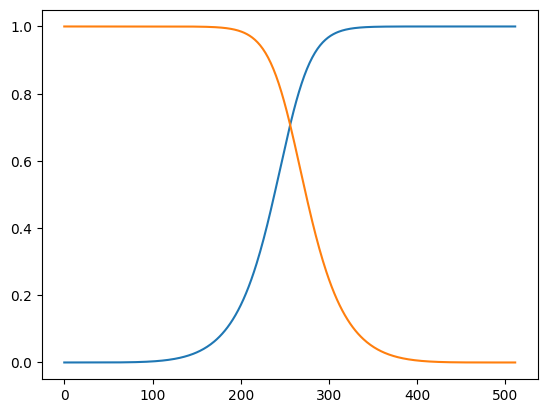

In [5]:
a, b = get_diff(d1, d2)
print(a.real)
print(b.real)
w, h1 = signal.freqz(a.real, b.real)

a, b = get_sum(d1, d2)
print(a.real)
print(b.real)
w, h2 = signal.freqz(a.real, b.real)

plt.plot(np.abs(h1))
plt.plot(np.abs(h2))
plt.show()

- Original Transfer Function & Frequency Response

$$
H_{lp}(z) = \frac{B_{lp}(z)}{A_{lp}(z)} \\
H_{hp}(z) = \frac{B_{hp}(z)}{A_{hp}(z)} \\
$$

[[ 5.27864045e-02  2.63932023e-01  5.27864045e-01  5.27864045e-01
   2.63932023e-01  5.27864045e-02]
 [ 1.00000000e+00 -2.16762652e-16  6.33436854e-01 -8.07743525e-17
   5.57280900e-02 -3.09353043e-18]]
[[ 5.27864045e-02 -2.63932023e-01  5.27864045e-01 -5.27864045e-01
   2.63932023e-01 -5.27864045e-02]
 [ 1.00000000e+00 -2.16762652e-16  6.33436854e-01 -8.07743525e-17
   5.57280900e-02 -3.09353043e-18]]


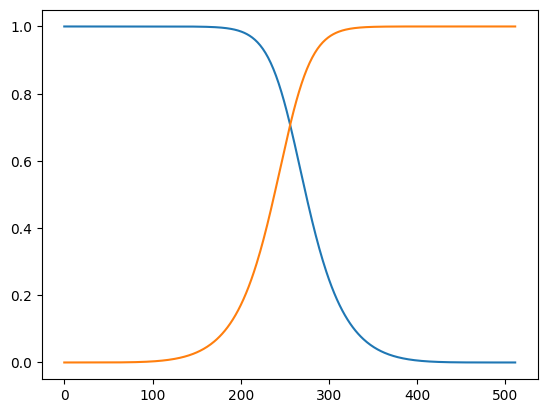

In [6]:
a0 = LP[1][0]
print(LP/a0)

a0 = HP[1][0]
print(HP/a0)

w, h1 = signal.freqz(LP[0], LP[1])
w, h2 = signal.freqz(HP[0], HP[1])

plt.plot(np.abs(h1))
plt.plot(np.abs(h2))
plt.show()